# Pokemon Card Classifier

In [34]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import sklearn.model_selection as ms
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# functions
def print_experiments(mnt_pt):
    for experiment in os.listdir(mnt_pt):
        experiment_path = mnt_pt + '/' + experiment
        print('Experiment {0} directory: {1}'.format(experiment, experiment_path))
        for directory in os.listdir(experiment_path):
            if directory == 'dataset':
                print('dataset path: {} \n'.format(experiment_path + '/' + directory))
            else:
                print('no dataset directory in experiment directory: {0}, subdirectories are: {1}'.format(experiment, os.listdir(experiment_path)))

In [36]:
mnt_pt = 'data'
print_experiments(mnt_pt)

Experiment base_set_classifier directory: data/base_set_classifier
dataset path: data/base_set_classifier/dataset 



In [37]:
### Constants
# file constants
dataset_path = 'data/base_set_classifier/dataset'
# data properties
img_size = (550,400) # (height, width) in pixels
color_mode = 'rgb'
batch_size = 32
random_seed = 20

## Exploratory Data Analysis

In [38]:
data_generator = ImageDataGenerator().flow_from_directory(dataset_path, target_size=(550,400), color_mode='rgb', batch_size=32, class_mode='binary',
                                                          shuffle=True, seed=42)
encoding_map = data_generator.class_indices
print('Dictionary mapping classes to numerical labels: {}'.format(encoding_map))

Found 10984 images belonging to 2 classes.
Dictionary mapping classes to numerical labels: {'not_base_set': 1, 'base_set': 0}


#### Class Frequency Histogram

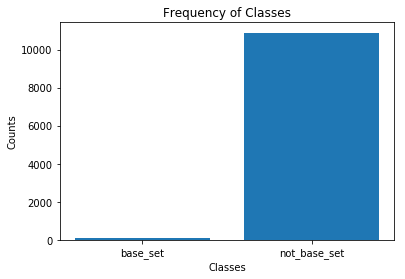

Number of samples in not_base_set class: 10882
Number of samples in base_set class: 102
Expected value for probability of drawing a not_base_set sample from our dataset: 0.9907137654770576
Expected value for probability of drawing a base_set sample from our dataset: 0.009286234522942461


In [39]:
all_labels = data_generator.labels
label_counts = np.asarray([np.sum((all_labels == label).astype(np.int32)) for label in encoding_map.values()])
plt.bar(encoding_map.values(), label_counts)
plt.xticks(list(encoding_map.values()), list(encoding_map.keys()))
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Frequency of Classes')
plt.show()
label_frequencies = label_counts / len(all_labels)
for name, num in np.squeeze(np.dstack((np.asarray(list(encoding_map.keys())), label_counts))):
    print('Number of samples in {0} class: {1}'.format(name, num))
for name, freq in np.squeeze(np.dstack((np.asarray(list(encoding_map.keys())), label_frequencies))):
    print('Expected value for probability of drawing a {0} sample from our dataset: {1}'.format(name, freq))

### Conclusions

We can clearly see from the above histogram that our dataset is very unbalanced and that we can expect an average (expected value) accuracy of 0.9907 for classification if we constructed a model that only predicted not_base_set for all examples in our sample dataset since the probability of encountering a non_base_set example is 0.9907. A classifier of this design would have great accuracy scores but would have trouble predicting examples that are truely base_set. This suggests that classification accuracy might not be the best measure of our models performance and that maybe we should look at the precision, recall, and F1 scores of our specific classes. Assuming our dataset sample is a representative sample of the total population of all possible base set pokemon card images and non base set pokemon card images that will ever be uploaded to the app then there would be no issue with the unbalancedness of this dataset, but if it isn't a representative sample of the population then our classifier would have a heavy bias on predicting not base set. This assumption is unlikely to be valid because there is no good reason to suggest that users would prefer to upload more images of one class than the other. Which means that a classifier trained on this dataset and cross validated for highest accuracy would most likely be heavily biased on labeling examples as non base set, and would perform pretty poorly when deployed.

There are a couple of ways we can deal with the above problem.
1. Undersample our most represented class, and maximize accuracy when we think our sample is representative. The issue though is the amount of examples of our under represented class (or over represented class after undersampling) might not be enough for our model to learn to identify them, and we would have to bias our model more in order to achieve better results (but overall worse results than our higher variance model trained on more data)
2. Oversample our under represented class, and maximize accuracy when we think our sample is representative. The issue with this solution is that at some point if we oversample too much the model might overtrain on the under represented class and not generalize well in deployment.
3. Oversample our under represented class with image augmentation. Again the downside to this solution is that our image augmentation might not be strong enough to produce examples that are different enough from the ones we started with and this will eventually cause overtraining.
4. Brute force search for model architectures that can learn to maximize our precision, recall, and F1 metrics from the limited amount of data we have for our under represented class. The problem with this solution is that the models we might find might not perform as well as we want on these metrics because the models that are capable of learning from our limited amount of data for our under represented class might be heavily biased, making the overall scores on our metrics not high.
5. Change our loss function to penalize wrong classification of the under represented class more than that of the over represented class.
6. Gather more data!!

## Model Development

Since we are more concerned with our model identifying base set examples than non base set examples the metrics we should be concerned with are the precision, recall and F1 scores for our base set class. **Since recall is essentially our accuracy score on predicting base set examples, and precision is our measure of certainty on our predictions of base set, we naturally would want to maximize both. This implies we should maximize our F1 score since it is the unweighted harmonic mean of our precision and recall scores.**

Solutions 1-3

#### Data Preprocessing

In [40]:
# Functions

def compresssed_dataset(dataset_path):
    classes = os.listdir(dataset_path)
    ds = []
    for c in classes:
        class_path = dataset_path + '/' + c
        imgs_of_c = os.listdir(class_path)
        ext = lambda img: class_path + '/' + img
        imgpaths_of_c = list(map(ext, imgs_of_c))
        samples_of_c = list(zip(imgpaths_of_c, [c for _ in range(len(imgpaths_of_c))]))
        ds.extend(samples_of_c)
    ds = np.asarray(ds)        
    return ds
        

"""

"""
def stratified_partitions(k, dataset_path, seed=None):
    random.seed(seed)
    classes = os.listdir(dataset_path)
    samples_of_classes = []
    for c in classes:
        samples_of_c = os.listdir(dataset_path + '/' + c)
        samples_of_c = list(zip(samples_of_c, [c for _ in range(len(samples_of_c))]))
        random.shuffle(samples_of_c)
        samples_of_classes.append(samples_of_c)
    if (min(list(map(len, samples_of_classes))) / k) < 1:
        raise Exception("cannot partition datset into {0} partitions and still keep each partition startified".format(k))
    partitions_of_classes = [[samples_of_class[i * (len(samples_of_class) // k) + min(i, len(samples_of_class) % k):(i+1) * (len(samples_of_class) // k) +
                                               min(i+1, len(samples_of_class) % k)] for i in range(k)] for samples_of_class in samples_of_classes]
    partitions = []
    num_classes = len(partitions_of_classes)
    for i in range(k):
        partition = []
        for c in range(num_classes):
            partition.extend(partitions_of_classes[c][i])
        random.shuffle(partition)
        partitions.append(partition)
    return partitions

"""
samples_per_class: dictionary, with keys that are the names of the different classes, and values that are the number of samples to draw from a specified 
                   class.
dataset_path: string or numpy array, a path to dataset with subfolders containing samples of a specific class with the name of the class as the 
              subfolde, or a numpy array where each row is a sample and the first column is filename and the second is label
replacement: dictionary, with keys that are the names of the different classes, and values that are boolean which specify whether sampling from the
             specified class should be done with replacement (True) or not (False)

returns: numpy array, of tuples, containing (path to image, label) representing the sampled dataset from the original dataset.
"""
def sample_dataset(samples_per_class, dataset, replacement, seed=None):
    random.seed(seed)
    sampled_set = []
    classes = np.unique(dataset[:,1])
    if samples_per_class == None:
        samples_per_class = {c: np.sum(dataset[:,1] == c) for c in classes}
    if replacement == None:
        replacement = {c: False for c in classes}
    for c in classes:
        imgpaths_per_c = dataset[dataset[:,1] == c]
        idx = np.random.choice(len(imgpaths_per_c), size=samples_per_class[c], replace=replacement[c])
        sampled_set.extend(imgpaths_per_c[idx])       
    return np.asarray(sampled_set)  

def encode(label):
    encoding = {'base_set': '1', 'not_base_set': '0'}
    return encoding[label]

def encode_dataframe(df):
    df['class'] = df['class'].map(encode)
    return df
    

In [41]:
# Splitting dataset into a train set, validation set, and test set
test_proportion = 1/5
val_proportion = 1/5

ds = compresssed_dataset(dataset_path)
filenames, labels = ds[:,0], ds[:,1]
names = np.unique(labels)

filenames_train_val, filenames_test, labels_train_val, labels_test = ms.train_test_split(filenames, labels, test_size=test_proportion, stratify=labels,
                                                                                         random_state=random_seed)
filenames_train, filenames_val, labels_train, labels_val = ms.train_test_split(filenames_train_val, labels_train_val, 
                                                                               test_size=(val_proportion/(1 - test_proportion)), 
                                                                               stratify=labels_train_val, random_state=random_seed)
train_size = len(filenames_train)
val_size = len(filenames_val)
test_size = len(filenames_test)
print('Number of samples in the training set: {}'.format(train_size))
print('Number of samples in the validation set: {}'.format(val_size))
print('Number of samples in the test set: {}\n'.format(test_size))
for name in names:
    num_of_name = np.sum(labels_train == name)
    print('Number of {0} samples in training set: {1}'.format(name, num_of_name))
print('')
for name in names:
    num_of_name = np.sum(labels_val == name)
    print('Number of {0} samples in validation set: {1}'.format(name, num_of_name))
print('')
for name in names:
    num_of_name = np.sum(labels_test == name)
    print('Number of {0} samples in test set: {1}'.format(name, num_of_name))

Number of samples in the training set: 6590
Number of samples in the validation set: 2197
Number of samples in the test set: 2197

Number of base_set samples in training set: 61
Number of not_base_set samples in training set: 6529

Number of base_set samples in validation set: 21
Number of not_base_set samples in validation set: 2176

Number of base_set samples in test set: 20
Number of not_base_set samples in test set: 2177


In [42]:
# Upsampling and downsampling datasets

class_samples_train = {'base_set': 100, 'not_base_set': 100}
class_samples_val = {'base_set': 40, 'not_base_set': 40}
class_samples_test = None

replacement_train = {'base_set': True, 'not_base_set': False}
replacement_val = {'base_set': True, 'not_base_set': False}
replacement_test = None

filenames_train, labels_train = sample_dataset(class_samples_train, np.squeeze(np.dstack((filenames_train, labels_train))), replacement_train, seed=random_seed).T
filenames_val, labels_val = sample_dataset(class_samples_val, np.squeeze(np.dstack((filenames_val, labels_val))), replacement_val, seed=random_seed).T
filenames_test, labels_test = sample_dataset(class_samples_test, np.squeeze(np.dstack((filenames_test, labels_test))), replacement_test, seed=random_seed).T

train_pd = encode_dataframe(pd.DataFrame({'filename': filenames_train, 'class': labels_train}))

val_pd = encode_dataframe(pd.DataFrame({'filename': filenames_val, 'class': labels_val}))
test_pd = encode_dataframe(pd.DataFrame({'filename': filenames_test, 'class': labels_test}))

In [43]:
val_pd.head()

,class,filename
0,1,data/base_set_classifier/dataset/base_set/swit...
1,1,data/base_set_classifier/dataset/base_set/star...
2,1,data/base_set_classifier/dataset/base_set/lass...
3,1,data/base_set_classifier/dataset/base_set/vulp...
4,1,data/base_set_classifier/dataset/base_set/ener...


In [44]:
# Augmenting datasets 
train_datagen = ImageDataGenerator(height_shift_range=0.5, rotation_range=90, horizontal_flip=True, vertical_flip=True)
valid_datagen = ImageDataGenerator(height_shift_range=0.5, rotation_range=90, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(height_shift_range=0.5, rotation_range=90, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(train_pd, target_size=img_size, class_mode='binary', batch_size=batch_size, drop_duplicates=False, seed=random_seed)
valid_generator = valid_datagen.flow_from_dataframe(val_pd, target_size=img_size, class_mode='binary', batch_size=batch_size, drop_duplicates=False, seed=random_seed)
test_generator = test_datagen.flow_from_dataframe(test_pd, target_size=img_size, class_mode='binary', batch_size=batch_size, drop_duplicates=False, seed=random_seed)

print(train_generator.class_indices)
print(valid_generator.class_indices)
print(test_generator.class_indices)

Found 200 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 2197 validated image filenames belonging to 2 classes.
{'0': 0, '1': 1}
{'0': 0, '1': 1}
{'0': 0, '1': 1}


#### Models

In [45]:
def model_1(): 
    inputs = k.Input(shape=(*img_size, 3))
    x = k.layers.Conv2D(5, (2,2), strides=(1,1), padding='same', 
                      input_shape=(*img_size, 3), activation='relu')(inputs)
    x = k.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
    x = k.layers.Conv2D(10, (5,5), strides=(1,1), padding='same', activation='relu')(x)
    x = k.layers.MaxPooling2D(pool_size=(5,5), strides=(5,5), padding='valid')(x)
    x = k.layers.Conv2D(25, (10,10), strides=(1,1), padding='same', activation='relu')(x)
    x = k.layers.MaxPooling2D(pool_size=(10,10), strides=(10,10), padding='valid')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dense(40, activation='relu')(x)
    x = k.layers.Dense(15, activation='relu')(x)
    x = k.layers.Dense(5, activation='relu')(x)
    predictions = k.layers.Dense(1, activation='sigmoid', use_bias=False)(x)
    model = k.models.Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001), loss=k.losses.BinaryCrossentropy(),
                  metrics=[k.metrics.BinaryAccuracy(), k.metrics.Precision(), k.metrics.Recall()])
    return model

#### Training and Cross-validating Models

In [46]:
model = model_1()
print(model.summary())

W0808 20:29:29.321953 140492141201152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0808 20:29:29.524790 140492141201152 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 550, 400, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 550, 400, 5)       65        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 275, 200, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 275, 200, 10)      1260      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 40, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 40, 25)        25025     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 4, 25)          0     

In [47]:
history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=2000, validation_data=valid_generator,
                              shuffle=True, validation_steps=100)

Epoch 1/10
2000/2000 [==============================] - 1866s 933ms/step - loss: 0.6744 - binary_accuracy: 0.5936 - precision: 0.7161 - recall: 0.3103 - val_loss: 0.6014 - val_binary_accuracy: 0.7957 - val_precision: 0.7497 - val_recall: 0.8877
Epoch 2/10
2000/2000 [==============================] - 1864s 932ms/step - loss: 0.4400 - binary_accuracy: 0.8344 - precision: 0.8027 - recall: 0.8867 - val_loss: 0.2264 - val_binary_accuracy: 0.8993 - val_precision: 0.8951 - val_recall: 0.9038
Epoch 3/10
2000/2000 [==============================] - 1861s 931ms/step - loss: 0.1659 - binary_accuracy: 0.9373 - precision: 0.9225 - recall: 0.9548 - val_loss: 0.1702 - val_binary_accuracy: 0.9349 - val_precision: 0.9794 - val_recall: 0.8888
Epoch 4/10
2000/2000 [==============================] - 1862s 931ms/step - loss: 0.1040 - binary_accuracy: 0.9629 - precision: 0.9560 - recall: 0.9705 - val_loss: 0.1749 - val_binary_accuracy: 0.9401 - val_precision: 0.9106 - val_recall: 0.9760
Epoch 5/10
2000/2000

In [48]:
# Evaluating Model
scores = model.evaluate(test_generator)

69/69 [==============================] - 70s 1s/step - loss: 0.2576 - binary_accuracy: 0.9363 - precision: 0.1154 - recall: 0.9000


In [51]:
# Saving Model

k.experimental.export_saved_model(model, 'models')

# Recreate the exact same model
new_model = k.experimental.load_from_saved_model('models')

W0809 02:07:07.416972 140492141201152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0809 02:07:07.417764 140492141201152 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0809 02:07:07.941749 140492141201152 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.uti